In [1]:
import numpy as np
import pygrgl
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/adityasyam/grg_pheno_sim') 

from grg_pheno_sim.effect_size import sim_grg_causal_mutation, additive_effect_sizes, samples_to_individuals, normalize_genetic_values
from grg_pheno_sim.model import grg_causal_mutation_model
from grg_pheno_sim.noise_sim import sim_env_noise
from grg_pheno_sim.normalization import normalize
from grg_pheno_sim.split import split_phenotypes


The following command only serves the purpose of converting the VCF zip file into a GRG that will be used for the phenotype simulation.

In [2]:
%%script bash --out /dev/null
echo "Test"
grg construct --no-maf-flip -p 10 -t 2 ../data/test-200-samples.vcf.gz --out-file test-200-samples.grg

Construction took 38 ms
Wrote GRG to test-200-samples.vcf.gz.part0.tree0.grg in 0 ms
Construction took 56 ms
Wrote GRG to test-200-samples.vcf.gz.part0.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took266 ms
Wrote GRG to test-200-samples.vcf.gz.part0.grg in 4 ms
Construction took 46 ms
Wrote GRG to test-200-samples.vcf.gz.part1.tree0.grg in 0 ms
Construction took 49 ms
Wrote GRG to test-200-samples.vcf.gz.part1.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took332 ms
Wrote GRG to test-200-samples.vcf.gz.part1.grg in 3 ms
Construction took 51 ms
Wrote GRG to test-200-samples.vcf.gz.part2.tree0.grg in 0 ms
Construction took 49 ms
Wrote GRG to test-200-samples.vcf.gz.part2.tree1.grg in 0 ms
Construction took 0 ms
Mapping mutations took455 ms
Wrote GRG to test-200-samples.vcf.gz.part2.grg in 4 ms
Construction took 59 ms
Wrote GRG to test-200-samples.vcf.gz.part3.tree0.grg in 0 ms
Construction took 107 ms
Wrote GRG to test-200-samples.vcf.gz.part3.tree1.grg in 0 m

In [3]:
grg_1 = pygrgl.load_immutable_grg("test-200-samples.grg") #loading in a sample grg stored in the same directory


In [4]:
rng = np.random.default_rng()

mean_1 = np.zeros(2)
cov_1 = np.eye(2) 
model_normal_multi = grg_causal_mutation_model("multivariate normal", mean=mean_1, cov=cov_1)

#simulating effect sizes using just the model
num_causal = 1000  #number of causal sites

effect_sizes = model_normal_multi.sim_effect_size(num_causal, rng)

print("Simulated Effect Sizes:", effect_sizes)

Simulated Effect Sizes: [[-2.3342404   0.01905034]
 [ 1.24244666 -1.15968713]
 [ 0.44682845 -0.54205219]
 ...
 [-0.55434117  0.36511714]
 [ 0.22735884  0.57264869]
 [ 0.27447639 -0.65033779]]


In [5]:
trait_df_normal_multi = sim_grg_causal_mutation(grg_1, num_causal=num_causal, model=model_normal_multi, random_seed=1)
sample_nodes_df_multi = additive_effect_sizes(grg_1, trait_df_normal_multi)
individuals = samples_to_individuals(sample_nodes_df_multi)
normalized_individual_multi_normal = normalize_genetic_values(individuals)


First, we will demonstrate how to simulate user-defined noise for multiple causal mutations (if the user does not want to use the h2 heritability feature). In this case, the user must specify the mean and covariance matrix to be used.

In [6]:
std_means = np.array([0, 0])
std_covariances = np.array([[1, 0], [0, 1]])
phenotypes_user_defined_multi_normal = sim_env_noise(individuals, user_defined=True, means=std_means, cov=std_covariances) #simulates noise from the multivariate standard normal distribution with means of zero and an identity matrix for covariance
phenotypes_user_defined_multi_normal_df = phenotypes_user_defined_multi_normal.phenotype_df
phenotypes_user_defined_multi_normal_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.387195,-37.555184
1,1,0,-23.087706,1.063349,-22.024357
2,0,1,-19.908226,-1.093771,-21.001997
3,1,1,-22.240029,1.292903,-20.947126
4,0,2,-9.933216,-0.795042,-10.728259
...,...,...,...,...,...
395,1,197,6.632294,-0.172704,6.459591
396,0,198,-28.121344,-0.496511,-28.617856
397,1,198,-17.527029,-0.593372,-18.120401
398,0,199,-10.601552,-0.225619,-10.827171


The user can extract the h2 assigned to any phenotype simulation as follows.

In [7]:
user_defined_multi_h2 = phenotypes_user_defined_multi_normal.get_h2()
print(user_defined_multi_h2)

[1.00354445 0.99555651]


In [8]:
split_phenotypes(phenotypes_user_defined_multi_normal_df, return_print=True)

     causal_mutation_id  individual_id  genetic_value  environmental_noise  \
0                     0              0     -37.942379             0.387195   
2                     0              1     -19.908226            -1.093771   
4                     0              2      -9.933216            -0.795042   
6                     0              3     -16.476328             0.988248   
8                     0              4     -39.004838            -0.028513   
..                  ...            ...            ...                  ...   
390                   0            195     -20.002154             0.916825   
392                   0            196     -27.360933            -0.959837   
394                   0            197     -23.888838            -0.597398   
396                   0            198     -28.121344            -0.496511   
398                   0            199     -10.601552            -0.225619   

     phenotype  
0   -37.555184  
2   -21.001997  
4   -10.7282

In [9]:
split_phenotypes_list = split_phenotypes(phenotypes_user_defined_multi_normal_df, return_list=True)
split_phenotypes_list[0] #the first dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.387195,-37.555184
2,0,1,-19.908226,-1.093771,-21.001997
4,0,2,-9.933216,-0.795042,-10.728259
6,0,3,-16.476328,0.988248,-15.488081
8,0,4,-39.004838,-0.028513,-39.033350
...,...,...,...,...,...
390,0,195,-20.002154,0.916825,-19.085328
392,0,196,-27.360933,-0.959837,-28.320769
394,0,197,-23.888838,-0.597398,-24.486236
396,0,198,-28.121344,-0.496511,-28.617856


In [10]:
split_phenotypes_list[1] #the second dataframe

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
1,1,0,-23.087706,1.063349,-22.024357
3,1,1,-22.240029,1.292903,-20.947126
5,1,2,-30.900956,0.985849,-29.915107
7,1,3,-27.909054,-0.047917,-27.956970
9,1,4,10.082859,-0.366948,9.715911
...,...,...,...,...,...
391,1,195,0.216175,1.257754,1.473929
393,1,196,-26.683542,-1.519586,-28.203127
395,1,197,6.632294,-0.172704,6.459591
397,1,198,-17.527029,-0.593372,-18.120401


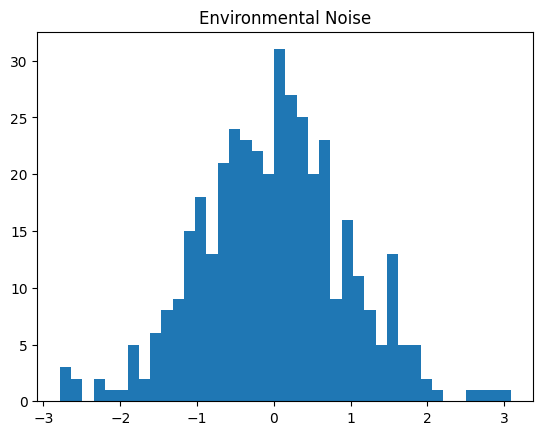

Mean of noise: -0.0009445587767488761
Standard deviation of noise: 0.9602800024355462


In [11]:

plt.hist(phenotypes_user_defined_multi_normal_df["environmental_noise"], bins=40)
plt.title("Environmental Noise")
plt.show()
print("Mean of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].mean()))
print("Standard deviation of noise: " + str(phenotypes_user_defined_multi_normal_df['environmental_noise'].std()))

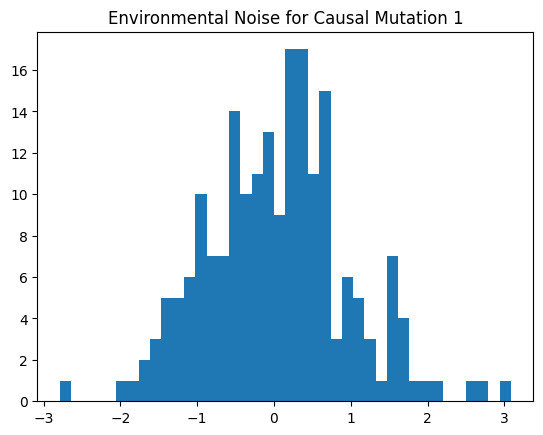

Mean of noise: 0.043705456777889035
Standard deviation of noise: 0.9266705368742801


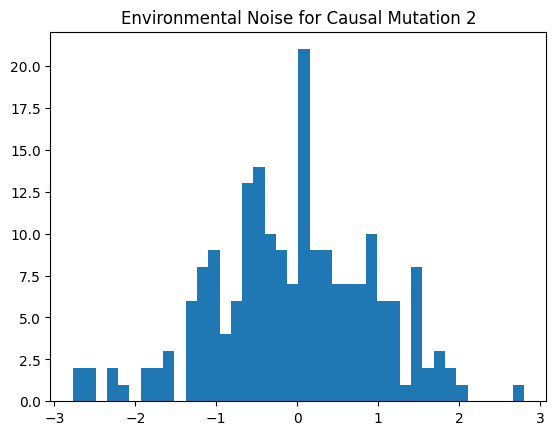

Mean of noise: -0.045594574331386785
Standard deviation of noise: 0.9930678001774161


In [12]:
df_dict_test = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_df.groupby('causal_mutation_id')}

num = len(df_dict_test)

for i in range(num):
  temp_df = df_dict_test[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [13]:
phenotypes_user_defined_multi_normal_df_normalized = normalize(phenotypes_user_defined_multi_normal)
phenotypes_user_defined_multi_normal_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.469679,0.032705,-1.436974
1,1,0,-0.974589,0.092677,-0.881912
2,0,1,0.247442,-0.108305,0.139138
3,1,1,-0.903746,0.111861,-0.791885
4,0,2,1.197213,-0.079861,1.117351
...,...,...,...,...,...
395,1,197,1.509184,-0.010623,1.498561
396,0,198,-0.534569,-0.051437,-0.586006
397,1,198,-0.509870,-0.045779,-0.555649
398,0,199,1.133577,-0.025644,1.107933


In [14]:
means = np.array([0, 0])
covariance = np.array([[1, 0.25], [0.25, 1]])
phenotypes_user_defined_multi_normal_special_cov = sim_env_noise(individuals, user_defined=True, means=means, cov=covariance) #simulating noise using a user-defined covariance matrix instead of the identity matrix
phenotypes_user_defined_multi_normal_special_cov_df = phenotypes_user_defined_multi_normal_special_cov.phenotype_df
phenotypes_user_defined_multi_normal_special_cov_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,-1.006427,-38.948806
1,1,0,-23.087706,-0.422324,-23.510030
2,0,1,-19.908226,-0.801468,-20.709694
3,1,1,-22.240029,-1.300423,-23.540452
4,0,2,-9.933216,-1.051642,-10.984859
...,...,...,...,...,...
395,1,197,6.632294,2.101328,8.733623
396,0,198,-28.121344,1.286152,-26.835192
397,1,198,-17.527029,-0.279140,-17.806169
398,0,199,-10.601552,0.756289,-9.845264


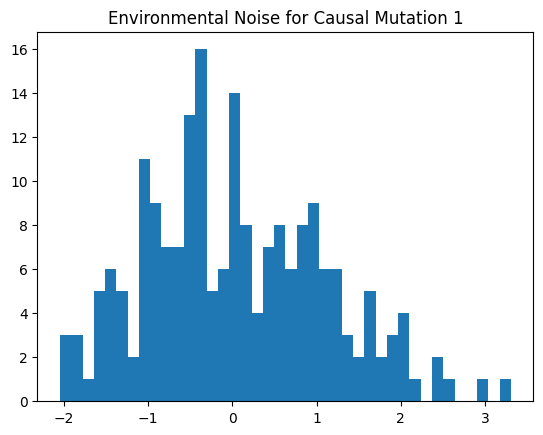

Mean of noise: 0.05041819594301548
Standard deviation of noise: 1.0775397861580194


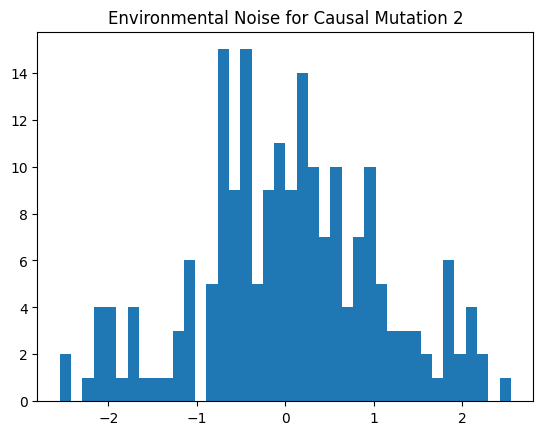

Mean of noise: 0.042732823462640554
Standard deviation of noise: 1.0385925956078237


In [15]:
df_dict_test_cov = {k: v.sort_values('individual_id') for k, v in phenotypes_user_defined_multi_normal_special_cov_df.groupby('causal_mutation_id')}

num = len(df_dict_test_cov)

for i in range(num):
  temp_df = df_dict_test_cov[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [16]:
phenotypes_user_defined_multi_normal_special_cov_df_normalized = normalize(phenotypes_user_defined_multi_normal_special_cov, normalize_genetic_values=True)
phenotypes_user_defined_multi_normal_special_cov_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.471226,-0.100733,-1.571959
1,1,0,-0.969550,-0.038665,-1.008215
2,0,1,0.247703,-0.081198,0.166505
3,1,1,-0.899074,-0.111670,-1.010744
4,0,2,1.198473,-0.105043,1.093430
...,...,...,...,...,...
395,1,197,1.501381,0.171152,1.672533
396,0,198,-0.535132,0.117784,-0.417348
397,1,198,-0.507233,-0.026761,-0.533994
398,0,199,1.134770,0.067280,1.202050


In [17]:
phenotypes_zero_noise = sim_env_noise(individuals) #simulates zero noise (assumes h2 is an array of 1s)
phenotypes_zero_noise_df = phenotypes_zero_noise.phenotype_df
phenotypes_zero_noise_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,0.0,-37.942379
1,1,0,-23.087706,0.0,-23.087706
2,0,1,-19.908226,0.0,-19.908226
3,1,1,-22.240029,0.0,-22.240029
4,0,2,-9.933216,0.0,-9.933216
...,...,...,...,...,...
395,1,197,6.632294,0.0,6.632294
396,0,198,-28.121344,0.0,-28.121344
397,1,198,-17.527029,0.0,-17.527029
398,0,199,-10.601552,0.0,-10.601552


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have not yet been normalized).

In [18]:
phenotype_multi_normal_h2 = sim_env_noise(individuals, h2=[0.5, 0.75]) #simulating environmental noise for 2 causal mutations without normalizing genetic values
phenotype_multi_normal_h2_df = phenotype_multi_normal_h2.phenotype_df
phenotype_multi_normal_h2_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-37.942379,16.405125,-21.537255
1,1,0,-23.087706,2.876340,-20.211366
2,0,1,-19.908226,0.261051,-19.647176
3,1,1,-22.240029,-12.527866,-34.767895
4,0,2,-9.933216,-6.556193,-16.489410
...,...,...,...,...,...
395,1,197,6.632294,0.234555,6.866850
396,0,198,-28.121344,8.877687,-19.243657
397,1,198,-17.527029,-6.809720,-24.336749
398,0,199,-10.601552,8.427836,-2.173716


In [19]:
print(phenotype_multi_normal_h2.get_h2()) #printing the h2 used for the simulation

[0.5, 0.75]


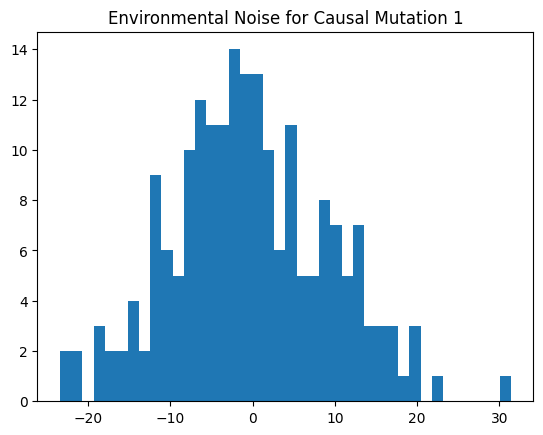

Mean of noise: -0.3636771400449691
Standard deviation of noise: 9.591425609382663


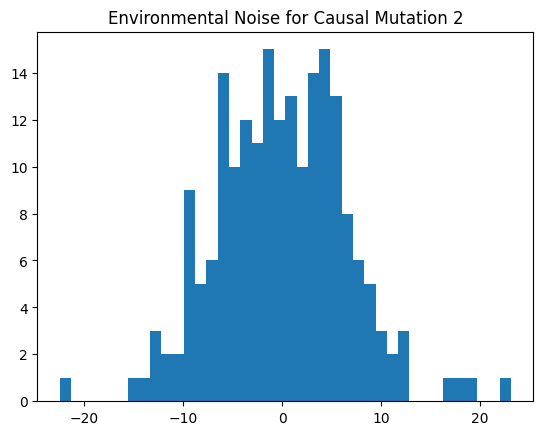

Mean of noise: -0.06528614955601253
Standard deviation of noise: 6.624532684049255


In [20]:
df_dict_test_pre_normal = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal)

for i in range(num):
  temp_df = df_dict_test_pre_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [21]:
phenotype_multi_normal_h2_df_normalized = normalize(phenotype_multi_normal_h2, normalize_genetic_values=True)
phenotype_multi_normal_h2_df_normalized

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.078247,1.171394,0.093147
1,1,0,-0.862557,0.217579,-0.644978
2,0,1,0.181539,0.043641,0.225180
3,1,1,-0.799858,-0.921801,-1.721658
4,0,2,0.878349,-0.432582,0.445767
...,...,...,...,...,...
395,1,197,1.335698,0.022178,1.357876
396,0,198,-0.392193,0.645561,0.253368
397,1,198,-0.451258,-0.498855,-0.950114
398,0,199,0.831662,0.614136,1.445798


In [22]:
df_dict_test_pre_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_multi_normal_h2_df_normalized.groupby('causal_mutation_id')}

num = len(df_dict_test_pre_normal_final)

for i in range(num):
  temp_df = df_dict_test_pre_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 1.0000000000000002
Variance of the genetic values for Causal Mutation 1 is 0.5359764943435107
Variance of the noise for Causal Mutation 1 is 0.44891909052108603
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.774431467672182
Variance of the noise for Causal Mutation 2 is 0.2400870629573255


Now, we show the usage of the narrow-sense heritability feature to simulate noise for multiple causal mutations (for a dataframe where genetic values have already been normalized).

In [23]:
phenotype_post_normalization = sim_env_noise(normalized_individual_multi_normal, h2=[0.25, 0.45]) #simulating noise after genetic values have been normalized
phenotype_df_post_normalization = phenotype_post_normalization.phenotype_df
phenotype_df_post_normalization

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-1.472805,0.049617,-1.423188
1,1,0,-0.980158,1.090331,0.110173
2,0,1,0.247969,-0.991420,-0.743452
3,1,1,-0.908911,0.126008,-0.782903
4,0,2,1.199759,3.379243,4.579002
...,...,...,...,...,...
395,1,197,1.517808,-1.431641,0.086167
396,0,198,-0.535707,-0.846822,-1.382529
397,1,198,-0.512783,-0.568364,-1.081147
398,0,199,1.135988,-0.117570,1.018418


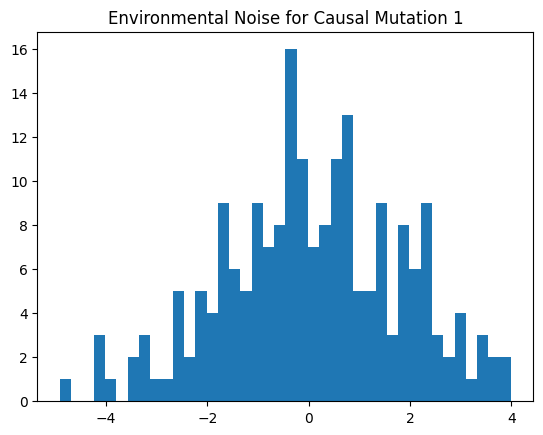

Mean of noise: 0.06528590475020973
Standard deviation of noise: 1.784093155369793


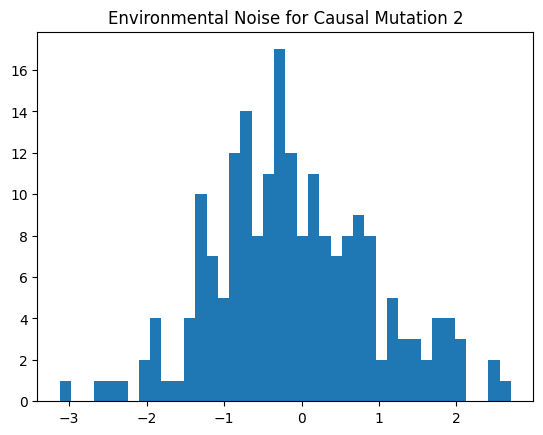

Mean of noise: -0.09203185012958998
Standard deviation of noise: 1.0410688265582646


In [24]:
df_dict_test_post_normal = {k: v.sort_values('individual_id') for k, v in phenotype_df_post_normalization.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal)

for i in range(num):
  temp_df = df_dict_test_post_normal[i]
  plt.hist(temp_df["environmental_noise"], bins=40)
  plt.title("Environmental Noise for Causal Mutation " + str(i+1) )
  plt.show()
  print("Mean of noise: " + str(temp_df['environmental_noise'].mean()))
  print("Standard deviation of noise: " + str(temp_df['environmental_noise'].std()))

In [25]:
phenotype_post_normalization_final_df = normalize(phenotype_post_normalization) #normalizing the final dataframe with the phenotypes
phenotype_post_normalization_final_df

,causal_mutation_id,individual_id,genetic_value,environmental_noise,phenotype
0,0,0,-0.735744,-0.007827,-0.743571
1,1,0,-0.674603,0.813773,0.139170
2,0,1,0.123873,-0.527881,-0.404007
3,1,1,-0.625567,0.150068,-0.475499
4,0,2,0.599343,1.655497,2.254840
...,...,...,...,...,...
395,1,197,1.044646,-0.921999,0.122647
396,0,198,-0.267614,-0.455646,-0.723260
397,1,198,-0.352928,-0.327840,-0.680768
398,0,199,0.567486,-0.091346,0.476140


In [26]:
df_dict_test_post_normal_final = {k: v.sort_values('individual_id') for k, v in phenotype_post_normalization_final_df.groupby('causal_mutation_id')}

num = len(df_dict_test_post_normal_final)

for i in range(num):
  temp_df = df_dict_test_post_normal_final[i]
  print("Variance of the phenotypes for Causal Mutation " + str(i+1) + " is "  + str(temp_df['phenotype'].var()))
  print("Variance of the genetic values for Causal Mutation " + str(i+1) + " is "  + str(temp_df['genetic_value'].var()))
  print("Variance of the noise for Causal Mutation " + str(i+1) + " is "  + str(temp_df['environmental_noise'].var()))

Variance of the phenotypes for Causal Mutation 1 is 0.9999999999999999
Variance of the genetic values for Causal Mutation 1 is 0.2495530573627254
Variance of the noise for Causal Mutation 1 is 0.7943244835352192
Variance of the phenotypes for Causal Mutation 2 is 1.0
Variance of the genetic values for Causal Mutation 2 is 0.4737015572998016
Variance of the noise for Causal Mutation 2 is 0.5134092595221652
